In [6]:
import numpy as np
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.exceptions import ConvergenceWarning
import random

class RobotNodeSystem:
    def __init__(self, grid,grid_row,grid_col,variation):
        self.grid = grid
        self.grid_row = grid_row
        self.grid_col = grid_col
        self.variation = variation
        self.current_position = (0, 0)
        self.visited_nodes = {}  # Use a dictionary to store visit counts for each node
        self.current_node_information = None
        self.decision_tree = AdaBoostClassifier(algorithm='SAMME')  # Initialize AdaBoostClassifier
        self.is_classifier_fitted = False
        self.min_reward_positions = []
        self.max_reward_positions = []
        self.memory_size = 30  # Number of recent positions to memorize
        self.visit_threshold = 30  # Threshold for revisiting a point
        self.punishment = -10  # Punishment for excessive revisits
        self.grid_change_interval = len(self.grid) // 2  # Number of steps before grid changes
        self.grid_change_probability = 0.1  # Probability of changing each grid element
        self.use_classifier = True  # Whether to use AdaBoost classifier
        self.reward = 0
        self.reward_collection = []
        self.explore_factor = 0.2 

    def move_randomly(self):
        # Generate all possible moves
        possible_moves = [('up', (self.current_position[0] - 1, self.current_position[1])),
                          ('down', (self.current_position[0] + 1, self.current_position[1])),
                          ('left', (self.current_position[0], self.current_position[1] - 1)),
                          ('right', (self.current_position[0], self.current_position[1] + 1))]

        # Calculate exploration probabilities for each move
        exploration_probs = []
        for move, pos in possible_moves:
            if self.is_valid_position(pos) and pos not in self.visited_nodes:
                exploration_probs.append(2.0)  # Assign higher exploration probability for unvisited positions
            else:
                exploration_probs.append(1.0)  # Assign lower exploration probability for visited positions

        # Normalize exploration probabilities
        total = np.sum(exploration_probs)
        exploration_probs = np.array(exploration_probs) / total

        # Choose a move based on exploration probabilities
        selected_move_index = np.random.choice(len(possible_moves), p=exploration_probs)
        selected_move, new_position = possible_moves[selected_move_index]

        # Move to the selected position
        self.move(selected_move)


    def move(self, direction):
        x, y = self.current_position
        if direction == 'up':
            new_position = (x - 1, y)
        elif direction == 'down':
            new_position = (x + 1, y)
        elif direction == 'left':
            new_position = (x, y - 1)
        elif direction == 'right':
            new_position = (x, y + 1)
        else:
            return
        
        if self.current_position in self.visited_nodes:
            if self.visited_nodes[self.current_position] > self.visit_threshold:
                self.reward += self.punishment
                self.reward_collection.append(self.reward)

        if self.is_valid_position(new_position):
            self.current_position = new_position
            self.update_visited_nodes(new_position)  # Update visit count
            self.current_node_information = self.grid[new_position[0]][new_position[1]]
            # Update decision tree with new data
            try:
                if self.use_classifier:
                    self.update_decision_tree()
            except:
                # If AdaBoostClassifier fails to fit, switch to random decision making
                self.use_classifier = False
        else:
            pass

    def is_valid_position(self, position):
        x, y = position
        return 0 <= x < len(self.grid) and 0 <= y < len(self.grid[0])

    def get_current_position(self):
        return self.current_position
    
    def get_visited_nodes(self):
        return self.visited_nodes

    def update_visited_nodes(self, position):
        # Update visit count for the given position
        if position in self.visited_nodes:
            self.visited_nodes[position] += 1
            # Apply punishment if the visit count exceeds the threshold
            if self.visited_nodes[position] > self.visit_threshold:
                self.visited_nodes[position] += self.punishment
        else:
            self.visited_nodes[position] = 1

    def update_decision_tree(self):
        # Convert visited nodes to features and targets
        visited_features = np.array(list(self.visited_nodes.keys()))
        visited_targets = np.array([self.grid[i][j] > 2 for i, j in self.visited_nodes.keys()])

        # Add last 30 positions to features
        recent_features = np.array(list(self.visited_nodes.keys())[-self.memory_size:])

        # Combine features and targets
        features = np.vstack([visited_features, recent_features])
        targets = np.concatenate([visited_targets, np.zeros(recent_features.shape[0], dtype=bool)])

        # Update decision tree
        self.decision_tree.fit(features, targets)
        self.is_classifier_fitted = True

    def is_position_great(self, position):
        try:
            if not self.is_classifier_fitted:
                return False  # Return default value if classifier is not fitted
                
            x, y = position  # Define variables x and y here
            
            if self.is_valid_position(position):
                prediction = self.decision_tree.predict(np.array([[x, y]]))[0]
                
                # Rotate decision based on min and max rotation points
                min_rotation_point = self.get_min_reward_position()
                max_rotation_point = self.get_max_reward_position()
                if min_rotation_point and max_rotation_point:
                    distance_to_min = np.linalg.norm(np.array(min_rotation_point) - np.array(position))
                    distance_to_max = np.linalg.norm(np.array(max_rotation_point) - np.array(position))
                    if distance_to_min < distance_to_max:
                        return not prediction
                return prediction
            else:
                return False
        except:
            return False



    def get_reward(self, position):
        if self.is_position_great(position):
            return np.random.uniform(5, 10)  # Reward for great position
        else:
            return np.random.uniform(-5, -10)  # Reward for non-great position


    def set_min_reward_position(self, position):
        self.min_reward_positions.append(position)

    def set_max_reward_position(self, position):
        self.max_reward_positions.append(position)

    def get_min_reward_position(self):
        if self.min_reward_positions:
            return self.min_reward_positions[-1]
        else:
            return None

    def get_max_reward_position(self):
        if self.max_reward_positions:
            return self.max_reward_positions[-1]
        else:
            return None

    def update_grid(self, memory_retention=0.1):
        # Retain a fraction of the visited nodes
        num_retain_nodes = int(len(self.visited_nodes) * memory_retention)
        self.visited_nodes = dict(list(self.visited_nodes.items())[:num_retain_nodes])

        # Retain a fraction of the min reward positions
        num_retain_min_positions = int(len(self.min_reward_positions) * memory_retention)
        self.min_reward_positions = self.min_reward_positions[:num_retain_min_positions]

        # Retain a fraction of the max reward positions
        num_retain_max_positions = int(len(self.max_reward_positions) * memory_retention)
        self.max_reward_positions = self.max_reward_positions[:num_retain_max_positions]

        self.decision_tree = AdaBoostClassifier(algorithm='SAMME') 

        # self.grid = np.random.randint(1, self.variation, size=(self.grid_row, self.grid_col))
        self.variation += 1

if __name__ == "__main__":
    grid_row = 100
    grid_col = 100
    variation = 50
    grid = np.random.randint(1, variation, size=(grid_row, grid_col))  # Generate random grid
    robot_system = RobotNodeSystem(grid,grid_row,grid_col,variation)

    num_steps = 1000 # Number of steps to take
    total_reward = 0
    total_reward_graph = []
    k = 0.9
    locations_x = []
    locations_y = []
    for step in range(num_steps):
        robot_system.use_classifier = True
        robot_system.move_randomly()
        current_position = robot_system.get_current_position()
        locations_x.append(current_position[0])
        locations_y.append(current_position[1])
        
        reward = robot_system.get_reward(current_position)
        total_reward += reward
        print(f"current position is {current_position} reward is: {reward}, total reward: {total_reward} step is: {step}")
        total_reward_graph.append(total_reward)
        if step % robot_system.grid_change_interval == 0:
            robot_system.update_grid(k)
            



current position is (0, 1) reward is: -5.941354268969534, total reward: -5.941354268969534
current position is (1, 1) reward is: -7.491489988605142, total reward: -13.432844257574676
current position is (1, 2) reward is: 7.6604011780219015, total reward: -5.772443079552774
current position is (1, 1) reward is: -5.937562263296994, total reward: -11.710005342849769
current position is (2, 1) reward is: -8.207215133922725, total reward: -19.917220476772492
current position is (2, 2) reward is: 7.426619836071414, total reward: -12.490600640701079
current position is (1, 2) reward is: -8.742479115673747, total reward: -21.233079756374828
current position is (1, 3) reward is: -5.062053243815876, total reward: -26.295133000190702
current position is (0, 3) reward is: -5.1828434657688955, total reward: -31.4779764659596
current position is (1, 3) reward is: -7.714297986057304, total reward: -39.1922744520169
current position is (1, 4) reward is: -6.046624026775383, total reward: -45.2388984787

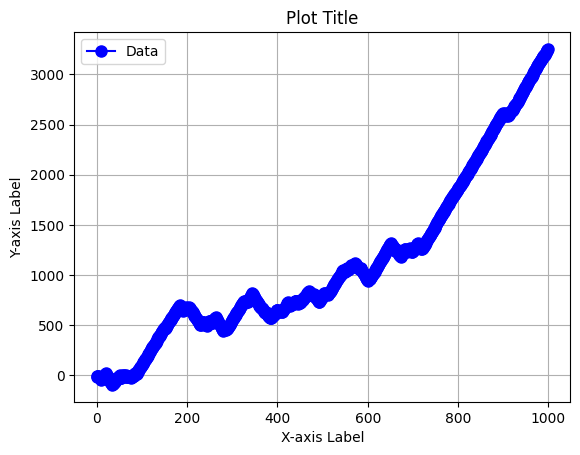

In [7]:
import matplotlib.pyplot as plt

# Example list of data
data = total_reward_graph

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the data with customized style
ax.plot(data, color='blue', linestyle='-', marker='o', markersize=8, label='Data')

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Plot Title')

# Add grid
ax.grid(True)

# Add legend
ax.legend()

# Show the plot
plt.show()


In [3]:
robot_system.visited_nodes

{(1, 1): 6,
 (0, 1): 7,
 (0, 0): 3,
 (0, 2): 7,
 (1, 2): 8,
 (2, 2): 6,
 (3, 2): 1,
 (3, 3): 1,
 (2, 3): 1,
 (2, 1): 4,
 (2, 0): 2,
 (1, 0): 3,
 (0, 3): 3,
 (0, 4): 3,
 (0, 5): 3,
 (0, 6): 2,
 (0, 7): 3,
 (0, 8): 3,
 (1, 8): 2,
 (1, 9): 1,
 (2, 8): 1,
 (3, 8): 1,
 (3, 7): 1,
 (2, 7): 1,
 (1, 7): 2,
 (1, 6): 1,
 (2, 6): 2,
 (3, 6): 1,
 (2, 5): 1,
 (1, 5): 1,
 (1, 4): 3,
 (1, 3): 3,
 (2, 4): 1}

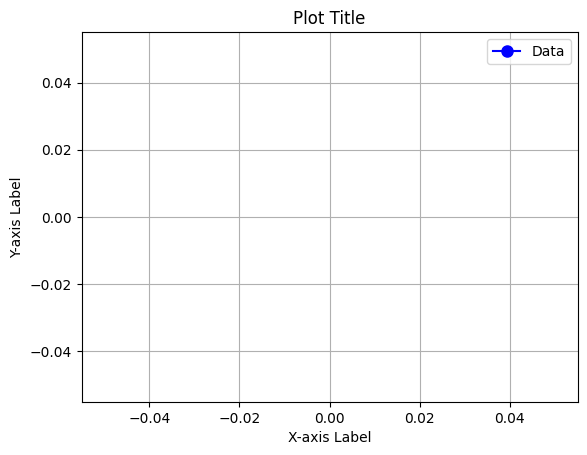

In [8]:
import matplotlib.pyplot as plt

# Example list of data
data = robot_system.reward_collection

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the data with customized style
ax.plot(data, color='blue', linestyle='-', marker='o', markersize=8, label='Data')

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Plot Title')

# Add grid
ax.grid(True)

# Add legend
ax.legend()

# Show the plot
plt.show()

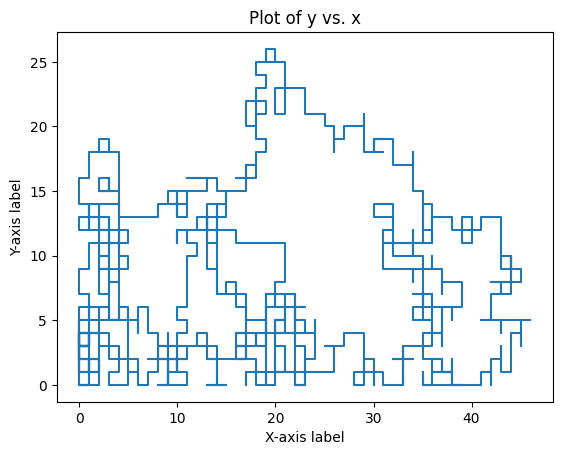

In [9]:
import matplotlib.pyplot as plt

# Plot
plt.plot(locations_x, locations_y)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Plot of y vs. x')

# Display the plot
plt.show()
